# Data Preparation for GuitarTab Project

This notebook prepares the Guitar Chords V2 dataset for training the Chord Prediction Model. It includes loading audio files, converting them into spectrograms, encoding labels, and creating TensorFlow datasets for efficient training.

02_data_preparation.ipynb main focus is on creating datasets for training:

## Table of Contents
1. [Import Libraries](#Import-Libraries)
2. [Define Paths and Parameters](#Define-Paths-and-Parameters)
3. [Load and Encode Labels](#Load-and-Encode-Labels)
4. [Create TensorFlow Datasets](#Create-TensorFlow-Datasets)
5. [Visualize Sample Spectrograms](#Visualize-Sample-Spectrograms)
6. [Conclusion and Next Steps](#Conclusion-and-Next-Steps)

In [10]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Verify path
print("Current working directory:", os.getcwd())
print("Python paths:", sys.path)

Current working directory: C:\Users\User\Documents\GitHub\GuitarTab\notebooks
Python paths: ['C:\\Users\\User\\Documents\\GitHub\\GuitarTab\\notebooks', 'C:\\Users\\User\\Documents\\GitHub\\GuitarTab\\notebooks\\%PYTHONPATH%', 'C:\\Users\\User\\Documents\\GitHub\\GuitarTab', 'C:\\Users\\User\\anaconda3\\python312.zip', 'C:\\Users\\User\\anaconda3\\DLLs', 'C:\\Users\\User\\anaconda3\\Lib', 'C:\\Users\\User\\anaconda3', '', 'C:\\Users\\User\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\User\\anaconda3\\Lib\\site-packages', 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\win32', 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\setuptools\\_vendor']


In [11]:
#!pip uninstall numpy librosa soundfile pooch -y

In [4]:
# Install specific numpy version compatible with other packages
#!pip install numpy==1.26.4

# Install librosa with compatible dependencies
#!pip install librosa==0.10.0 soundfile==0.12.1 numba==0.59.0

In [12]:
# 1. Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from src.data_preprocessing import (
    get_file_paths, encode_labels, compute_mel_spectrogram, 
    create_tf_datasets, preprocess_function
)
import seaborn as sns
import pandas as pd

In [13]:
# In your terminal/CMD/PowerShell:
#python -c "import librosa; print(librosa.__version__)"

## 2. Define Paths and Parameters

Set the paths to your datasets and define any necessary parameters.

In [14]:
# 2. Define Paths and Parameters
DATA_DIR = r"C:\Users\User\Documents\GitHub\GuitarTab\Guitar_Chords_V2"
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Test')
chords = ['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
batch_size = 16
num_classes = len(chords)

In [15]:
def verify_paths():
    required_chords = ['Am', 'Bb', 'Bdim', 'C', 'Dm', 'Em', 'F', 'G']
    
    # Check base directories
    assert os.path.exists(DATA_DIR), f"Missing base directory: {DATA_DIR}"
    assert os.path.exists(TRAIN_DIR), f"Missing training directory: {TRAIN_DIR}"
    assert os.path.exists(TEST_DIR), f"Missing test directory: {TEST_DIR}"
    
    # Check chord subfolders
    for split in [TRAIN_DIR, TEST_DIR]:
        for chord in required_chords:
            chord_dir = os.path.join(split, chord)
            assert os.path.exists(chord_dir), f"Missing chord directory: {chord_dir}"
            assert len(os.listdir(chord_dir)) > 0, f"No files in {chord_dir}"
    
    print("All paths validated successfully!")

verify_paths()

All paths validated successfully!


## 3. Load and Encode Labels

Retrieve file paths and encode labels numerically and categorically.

In [16]:
# 3. Load and Encode Labels
train_files, train_labels = get_file_paths(TRAIN_DIR, chords)
test_files, test_labels = get_file_paths(TEST_DIR, chords)
print(f"Number of training samples: {len(train_files)}")
print(f"Number of testing samples: {len(test_files)}")

# Encode labels
label_encoder, train_labels_cat = encode_labels(train_labels)
_, test_labels_cat = encode_labels(test_labels)
print(f"Encoded labels: {label_encoder.classes_}")

Number of training samples: 1440
Number of testing samples: 320
Encoded labels: ['Am' 'Bb' 'Bdim' 'C' 'Dm' 'Em' 'F' 'G']


## 4. Create TensorFlow Datasets

Convert file paths and labels into TensorFlow datasets for efficient loading and preprocessing during training.

In [17]:
# 4. Create TensorFlow Datasets
train_dataset, validation_dataset = create_tf_datasets(
    train_files, train_labels_cat, 
    test_files, test_labels_cat,
    batch_size=batch_size, 
    num_classes=num_classes
)

print("Training Dataset:")
for spectrogram, label in train_dataset.take(1):
    print(spectrogram.shape, label.shape)
print("Validation Dataset:")
for spectrogram, label in validation_dataset.take(1):
    print(spectrogram.shape, label.shape)

Training Dataset:
(16, 128, 128, 1) (16, 8)
Validation Dataset:
(16, 128, 128, 1) (16, 8)


## 5. Visualize Sample Spectrograms

Visualize spectrograms to ensure data preprocessing is correct and to gain insights into the input data.

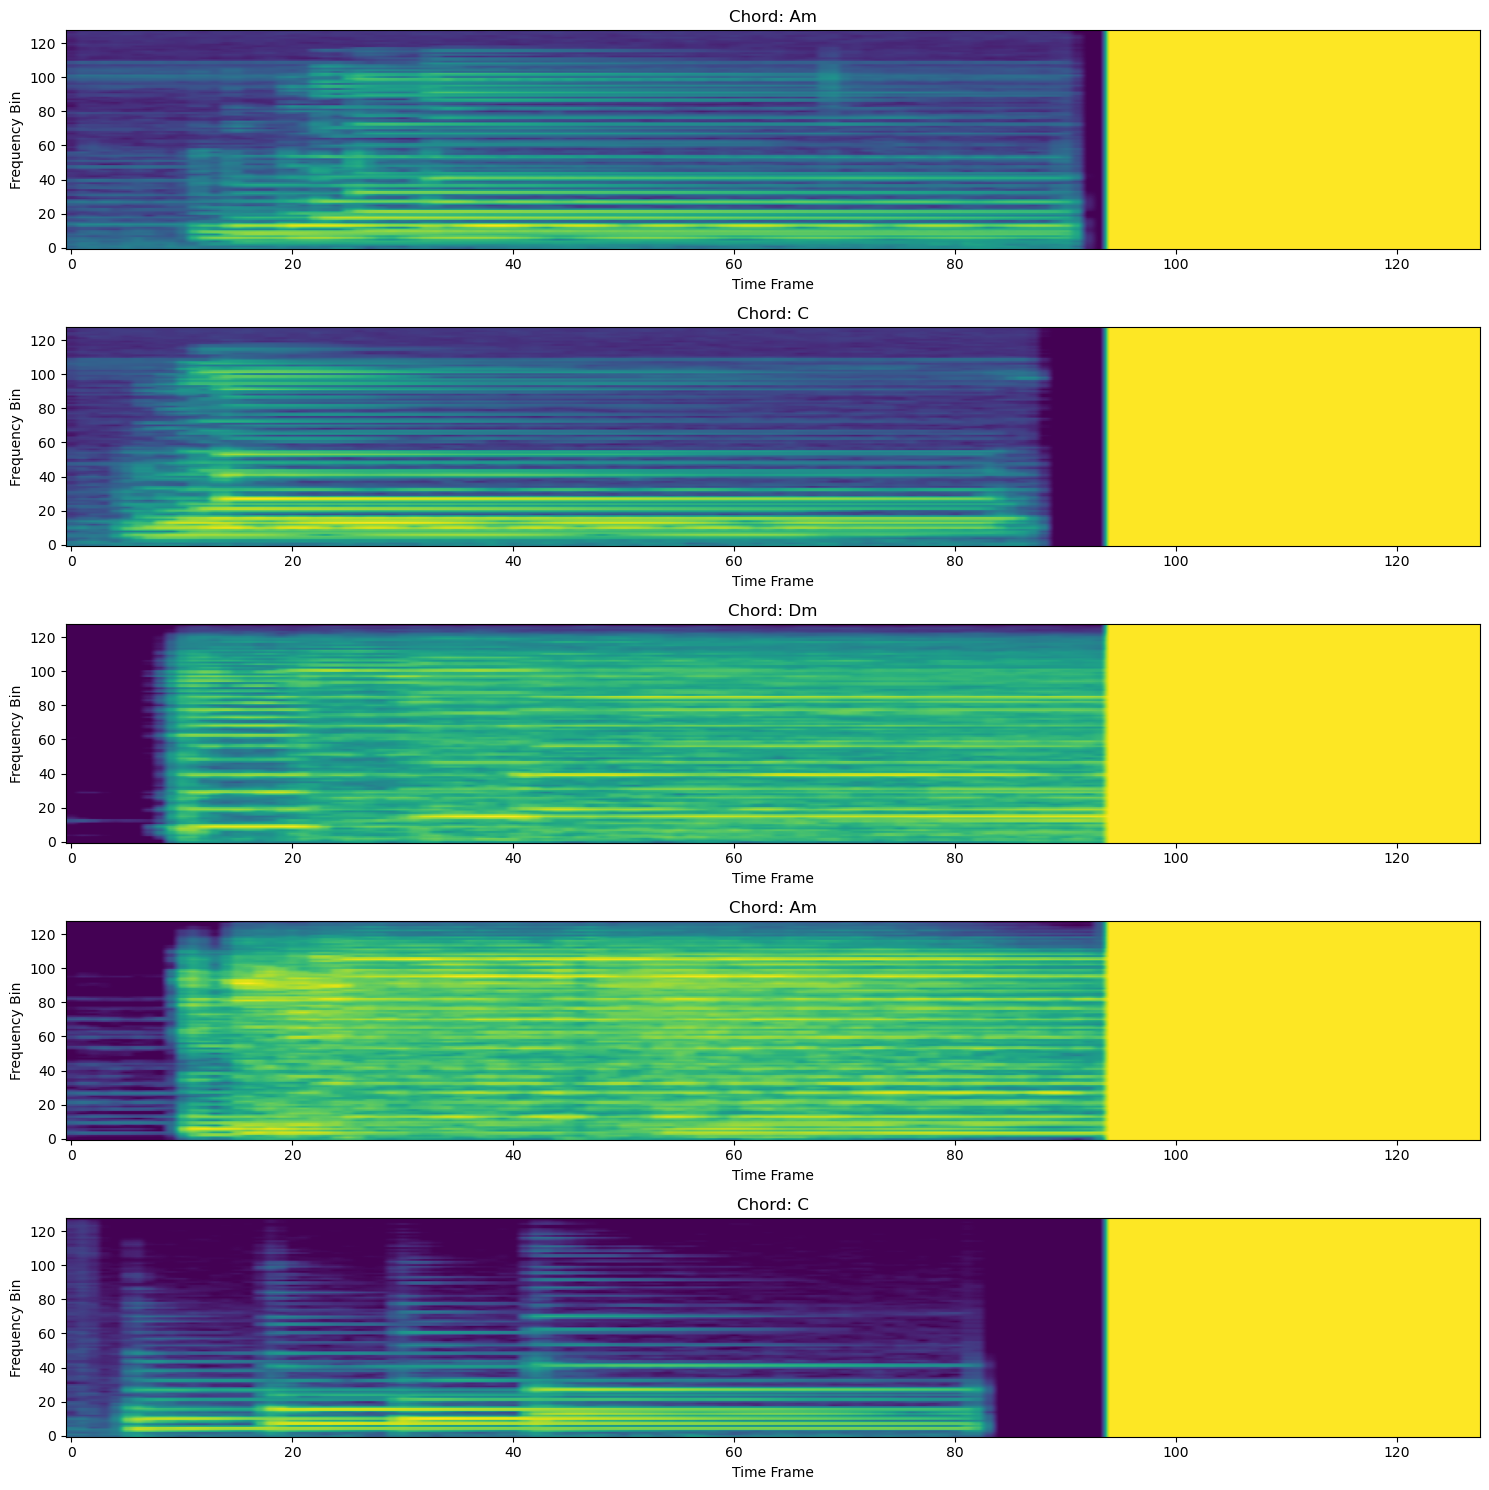

In [19]:
# 5. Visualize Sample Spectrograms
def visualize_samples(dataset, label_encoder, num_samples=5):
    dataset = dataset.unbatch()  # Critical fix
    class_names = label_encoder.classes_
    plt.figure(figsize=(15, num_samples * 3))
    for i, (spectrogram, label) in enumerate(dataset.take(num_samples)):
        spectrogram = spectrogram.numpy().squeeze()  # Now (128, 128)
        label = label.numpy()
        predicted_label = class_names[np.argmax(label)]
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f"Chord: {predicted_label}")
        plt.xlabel("Time Frame")
        plt.ylabel("Frequency Bin")
    plt.tight_layout()
    plt.show()
# Visualize 5 samples from training dataset
visualize_samples(train_dataset, label_encoder, num_samples=5)

In [20]:
print("Dataset preparation complete. Ready for model training!")
print(f"Training dataset: {len(train_files)} samples")
print(f"Validation dataset: {len(test_files)} samples")
print(f"Input shape: (128, 128, 1)")
print(f"Output shape: {num_classes} classes")

Dataset preparation complete. Ready for model training!
Training dataset: 1440 samples
Validation dataset: 320 samples
Input shape: (128, 128, 1)
Output shape: 8 classes


## 6. Conclusion and Next Steps

- **Data Prepared**: Audio files have been loaded, preprocessed, and converted into spectrograms suitable for model training.
- **Datasets Created**: TensorFlow datasets for training and validation are ready.
- **Visual Verification**: Sample spectrograms have been visualized to ensure preprocessing correctness.

### **Next Steps**
- On Day 3, proceed to **Developing the Chord Prediction Model** by defining and training a CNN using the prepared datasets.